In [22]:
from pylab import *
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as img
from numpy import random
import cv2 as cv
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # for auto-labelling the datasets based on the folders they are in
from tensorflow.keras.preprocessing import image

In [3]:
training_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/training/"
testing_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/testing/"
prediction_path = "/kaggle/input/landscape-classifier/Landscape_classifier_02/prediction/"
prediction_path_0 = "/kaggle/input/landscape-classifier/Landscape_classifier_02/prediction/prediction/"

In [4]:
# pick randomly images from prediction dataset to obtain knowledge about the sizes of the images

image0 = cv.imread(prediction_path_0+os.listdir(prediction_path_0)[random.randint(0,len(os.listdir(prediction_path_0)))])
image0.shape

# which says all images are RGB and 150*150

(150, 150, 3)

In [5]:
path = f"/kaggle/input/landscape-classifier/Landscape_classifier_02"
dir_list = os.listdir(path)  
# print the list 
print(dir_list)

['training', 'prediction', 'testing']


In [6]:
def visualize(K,row_num, col_num):    # An image visualization function
    image_store = []
    img_loc = []
    for i in range(0,row_num*col_num):
        image_store.append(K+os.listdir(K)[i])
        
    for item in image_store:
        img_loc.append(cv.imread(item))
    f, axarr = plt.subplots(row_num, col_num,figsize=(14,14))
    f.tight_layout()
    f.suptitle("Images in Prediction dataset",size=18,fontweight="bold")
    f.subplots_adjust(top=0.95)
    
    for i in range(0, row_num*col_num):
        axarr[int(i/col_num),int(i%col_num)].imshow(img_loc[i])
        

def PlotAccuracy(Hist):
    plt.plot(Hist.history['accuracy'])
    plt.plot(Hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def PlotLoss(Hist):
    plt.plot(Hist.history['loss'])
    plt.plot(Hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def PlotTrainBehaviour(Hist):
    PlotAccuracy(Hist)
    PlotLoss(Hist)
    
    
def PrintProgress(Hist):
    init_training_accuracy = Hist.history['accuracy'][0] * 100
    end_training_accuracy = Hist.history['accuracy'][len(Hist.history['accuracy'])-1] * 100

    init_val_accuracy = Hist.history['val_accuracy'][0] * 100
    end_val_accuracy = Hist.history['val_accuracy'][len(Hist.history['accuracy'])-1] * 100

    print("\n")                                                           
    print("Evolution of Training Accuracy : " + str(init_training_accuracy) + " % --> " + str(end_training_accuracy) + " % \n")
    print("Evolution of Validation Accuracy : " + str(init_val_accuracy) + " % --> " + str(end_val_accuracy)+" % \n")

    print("training terminated at : "+str(len(Hist.history['loss']))+"-th epoch \n")

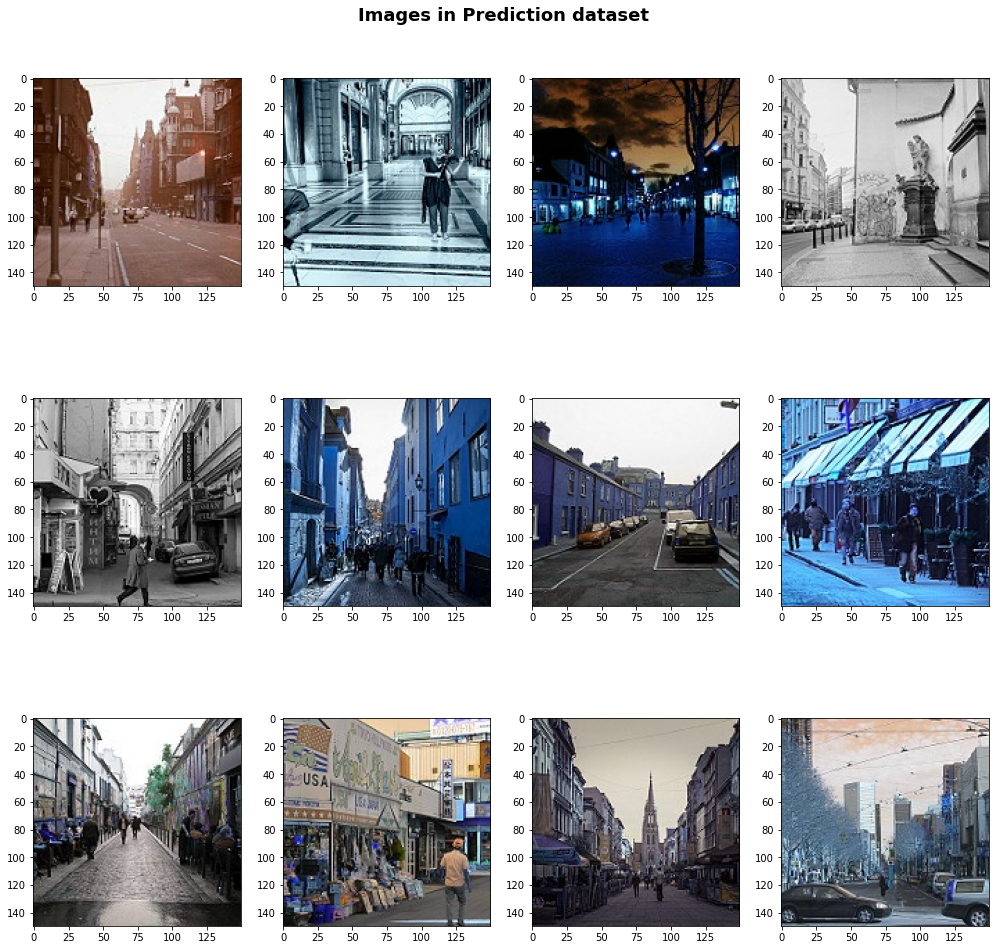

In [11]:
visualize(training_path+"street"+'/', 3, 4)

In [12]:
train = ImageDataGenerator(rescale=1.0/255.0)
validation = ImageDataGenerator(rescale=1.0/255.0)
prediction = ImageDataGenerator(rescale=1.0/255.0) 


training_dataset = train.flow_from_directory(training_path,        # although all the images are of equal size 150*150 - we can still scale it down to 100*100 due to general practice
											target_size=(150,150),
											batch_size = 10,
											class_mode='categorical')

validation_dataset = validation.flow_from_directory(testing_path,
											target_size=(150,150),
											batch_size = 10,
											class_mode='categorical')

prediction_dataset = prediction.flow_from_directory(prediction_path,
                                                    target_size=(150,150),
                                                    batch_size = 1,
                                                    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 7301 images belonging to 1 classes.


In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## The Model

In [16]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(150,150,3))
flatten = layers.Flatten()
dense1 = layers.Dense(150, activation='relu',  kernel_regularizer='l2')   # Implementing L2 Regularization (eventual_squared-weight-decay during training)
dense2 = layers.Dense(150, activation='relu',  kernel_regularizer='l2')
dense_out = layers.Dense(6, activation='softmax')
drop_out = layers.Dropout(0.55)

# dense3 = layers.Dense(6, activation='softmax')
x = flatten(inputs)
x = dense1(x)
x = drop_out(x)         # Implementing random dropout of 42% of the weights
x = dense2(x)
x = drop_out(x)
outputs = dense_out(x)

model_1 = keras.Model(inputs = inputs, outputs = outputs, name='prikarsartams_regularised_feedforward_image_classifier_without_CNN')

print(model_1.summary())

Model: "prikarsartams_regularised_feedforward_image_classifier_without_CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 67500)        0           input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 150)          10125150    flatten_1[0][0]                  
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 150)          0           dense_3[0][0]                    
                                 

In [17]:
model_1.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adagrad(              # Using Adaptive Gradient Algorithm - Adagrad 
                             learning_rate=0.001,
                             initial_accumulator_value=0.1,
                             epsilon=1e-07,
                             name="Adagrad"),
                metrics=['accuracy'])

# model_1.compile(loss='categorical_crossentropy',
#                 optimizer= 'adagrad',
#                 metrics=['accuracy'])

In [18]:
%%time
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=8)  # Earlystop Implementation 
history_1 = model_1.fit(training_dataset, validation_data = validation_dataset, epochs=500, verbose=1, callbacks=[early_stop])   # calling Earlystop as callback during the break in between the epochs

Epoch 1/500
1404/1404 [==============================] - 56s 39ms/step - loss: 5.9477 - accuracy: 0.1714 - val_loss: 5.5928 - val_accuracy: 0.1777
Epoch 2/500
1404/1404 [==============================] - 27s 19ms/step - loss: 5.2802 - accuracy: 0.1803 - val_loss: 4.9637 - val_accuracy: 0.2600
Epoch 3/500
1404/1404 [==============================] - 27s 19ms/step - loss: 4.7258 - accuracy: 0.2047 - val_loss: 4.4333 - val_accuracy: 0.2740
Epoch 4/500
1404/1404 [==============================] - 27s 19ms/step - loss: 4.2695 - accuracy: 0.2129 - val_loss: 4.0069 - val_accuracy: 0.2660
Epoch 5/500
1404/1404 [==============================] - 27s 20ms/step - loss: 3.8884 - accuracy: 0.2163 - val_loss: 3.6707 - val_accuracy: 0.2803
Epoch 6/500
1404/1404 [==============================] - 27s 19ms/step - loss: 3.5625 - accuracy: 0.2195 - val_loss: 3.3727 - val_accuracy: 0.2797
Epoch 7/500
1404/1404 [==============================] - 27s 19ms/step - loss: 3.2891 - accuracy: 0.2210 - val_loss: 3



Evolution of Training Accuracy : 17.13695377111435 % --> 52.45118737220764 % 

Evolution of Validation Accuracy : 17.766666412353516 % --> 53.66666913032532 % 

training terminated at : 155-th epoch 



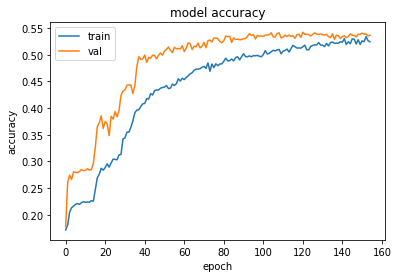

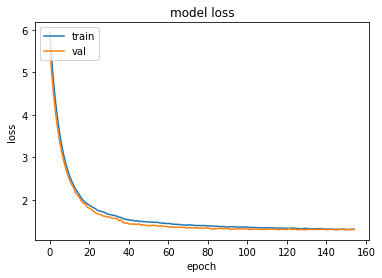

In [19]:
PrintProgress(history_1)
PlotTrainBehaviour(history_1)
model_1.save('/kaggle/working/model_1.h5')

In [23]:
# Predicting the Test set results
prediction_set = model_1.predict(prediction_dataset, steps=len(prediction_dataset), verbose=1)

# Getting the predicted class
predicted_class_indices=np.argmax(prediction_set,axis=1)          # MaxPooling the labels from the last layer output

# Getting the labels
labels = (training_dataset.class_indices)                         # taking the labels from the training folder since the prediction dataset isn't labelled in the dataset provided
labels = dict((v,k) for k,v in labels.items())                    
predictions = [labels[k] for k in predicted_class_indices]        # put the for loop inside the array_index of the properties

# Getting the filenames
filenames=prediction_dataset.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                     "class_index": predicted_class_indices})     # make a dataframe out of the results obtained so far
 

results.to_csv("results_from_rFF_0.csv",index=True)               # make a CSV (Comma Seperated Values) [just like json] file out of the results

7301/7301 [==============================] - 17s 2ms/step


In [24]:
path_to_saved_result = '/kaggle/working/results_from_rFF_0.csv'

In [25]:
classified_images = pd.read_csv(path_to_saved_result)

## The classified Images from Prediction Set

In [26]:
classified_images[:20]   # displaying first 20 classified instances

,Unnamed: 0,Filename,Predictions,class_index
0,0,prediction/10004.jpg,sea,4
1,1,prediction/10005.jpg,glacier,2
2,2,prediction/10012.jpg,glacier,2
3,3,prediction/10013.jpg,glacier,2
4,4,prediction/10017.jpg,street,5
5,5,prediction/10021.jpg,glacier,2
6,6,prediction/1003.jpg,mountain,3
7,7,prediction/10034.jpg,street,5
8,8,prediction/10038.jpg,mountain,3
9,9,prediction/10040.jpg,glacier,2
